In [2]:
import dask 
import xarray as xr 
import numpy as np 
import os

# build a parallel netcdf dataset. each .nc file is a different part of the grid. 
# grid is uniform (though varies in x, y, z), with no refinement (yt level 0 only)
# uses dask to build sample data on each grid, write to nc

def build_write_chunk(chunk_bbox, chunk_sizes, chunk_linear_index: int):
    new_file = f"data/chunk_{chunk_linear_index}.nc"
    if os.path.isfile(new_file): 
        return 
    
    xcoords = np.linspace(chunk_bbox[0][0], chunk_bbox[0][1], chunk_sizes[0])
    ycoords = np.linspace(chunk_bbox[1][0], chunk_bbox[1][1], chunk_sizes[1])
    zcoords = np.linspace(chunk_bbox[2][0], chunk_bbox[2][1], chunk_sizes[2])

    x1 = xr.Dataset(
        {
        "temperature": (("x", "y", "z"), 20 * np.random.rand(*chunk_sizes)),
        },
        coords={"x": xcoords, "y": ycoords, "z": zcoords},
    )
    x1.to_netcdf(path=new_file)


n_grids = (5, 5, 5)
grid_wids = np.array([1., 1., 1.])
cells_per_grid = np.array([65, 70, 80])
cell_sizes = grid_wids / cells_per_grid 
hwidth = cell_sizes / 2

igrid_index = 0
write_grids = []
for igrid_x in range(n_grids[0]):
    for igrid_y in range(n_grids[1]):
        for igrid_z in range(n_grids[2]):
            igrid = np.array([igrid_x, igrid_y, igrid_z])
            left_edge = grid_wids * igrid + hwidth 
            right_edge = left_edge + grid_wids - cell_sizes
            this_grid = np.column_stack([left_edge, right_edge])
            #build_write_chunk(this_grid, cells_per_grid, igrid)
            
            write_grids.append(dask.delayed(build_write_chunk)(this_grid, cells_per_grid, igrid_index))
            igrid_index += 1

In [3]:
_ = dask.compute(*write_grids)

In [4]:
# https://docs.xarray.dev/en/stable/user-guide/dask.html#reading-and-writing-data
ds_xr = xr.open_mfdataset("data/*.nc", parallel=True)

HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Ao

above warnings come from conda mismatching libraries. shoudl re-do this in a clean enviro...

https://stackoverflow.com/questions/74226436/hdf5-error-when-opening-nc-files-in-python-with-xarray/74248405#74248405 

still seems OK:

In [5]:
ds_xr

<xarray.Dataset>
Dimensions:      (x: 325, y: 350, z: 400)
Coordinates:
  * x            (x) float64 0.007692 0.02308 0.03846 ... 4.962 4.977 4.992
  * y            (y) float64 0.007143 0.02143 0.03571 0.05 ... 4.964 4.979 4.993
  * z            (z) float64 0.00625 0.01875 0.03125 ... 4.969 4.981 4.994
Data variables:
    temperature  (x, y, z) float64 dask.array<chunksize=(65, 70, 80), meta=np.ndarray>

In [6]:
Txz = ds_xr.temperature.isel({"y":0})

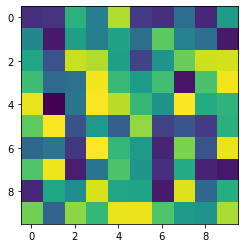

In [7]:
import matplotlib.pyplot as plt 
plt.imshow(Txz[0:10, 0:10])

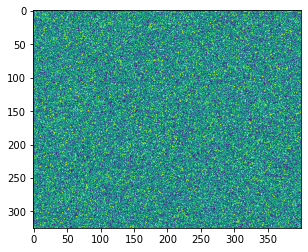

In [9]:
Txz.shape
plt.imshow(Txz)

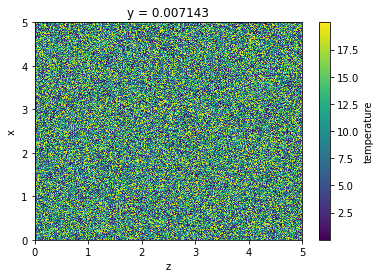

In [10]:
Txz.plot()

## load via callables 

now if we load it as a callable... 